## Pre-Processing

In [127]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, re, glob, math, types, sys, warnings
import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.signal import butter, filtfilt, iirnotch, welch, detrend
from sklearn.decomposition import PCA, FastICA
from scipy.stats import kurtosis
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Config

In [107]:
OUT_DIR  = "./outputs"
DATA_DIR = "./data"

FS = 200  # Hz

# Tasks: absolute video schedule (start sec, length 30s; last task truncated to 30s)
ABS_TASKS = [
    ("Rest",          27, 30),
    ("Math",          61, 30),
    ("Music",         95, 30),
    ("Video",        132, 30),
    ("Retrieval",    182, 30),
    ("ColorCounting",238, 30),
]

# Fallback sequential schedule if file is shorter than last absolute end
SCHEDULE_MODE = "auto"     # "absolute" | "sequential" | "auto"
SEQ_START_SEC = 0.0
TASK_ORDER = ["Rest","Math","Music","Video","Retrieval","ColorCounting"]
TASK_DUR_SEC = {t: 30 for t in TASK_ORDER}
ALLOW_SHORT_SEGMENTS = True   # allow <30s seg if >=15s exists (for epoch search)

# Epoch & artifact rules
CLEAN_EPOCH_SEC = 15
SPIKE_THRESHOLD_UV = 50.0  # ±50 µV

# Filtering
NOTCH_HZ = 50.0
BANDPASS = (1, 40.0)

# Welch PSD (Hann, 2 s, 50% overlap, median)
N_PERSEG = int(2.0 * FS)        # 400
N_OVERLP = int(0.5 * N_PERSEG)  # 200

# Units
UNITS = "uV"  # set to "counts" ONLY if your CSVs are raw integers
SCALE_UV_PER_COUNT = 0.001869917138805

# Re-reference & channel combine — used only for epoch row export
REREF = "car"          # "none" | "car"
COMBINE_METHOD = "pca1"  # "mean"|"rms"|"pca1"|"ch1"|"ch2"|"ch3"|"ch4"

# Channel labels & groups (your montage: Fp1, Fp2, F7, F8)
CHANNEL_LABELS = ["Fp1","Fp2","F7","F8"]
CHANNEL_GROUPS = {
    "all": [0,1,2,3],
    "frontopolar": [0,1],       # Fp1, Fp2 (blink-prone; frontal-theta)
    "lateral_frontal": [2,3],   # F7, F8 (blink-resistant; use for TBR/beta/alpha)
}

warnings.simplefilter("ignore", RuntimeWarning)


### Load files

In [108]:
def ensure_dir(p): os.makedirs(p, exist_ok=True)

def parse_type_and_day(fname: str):
    base = os.path.basename(fname).lower()
    if   any(x in base for x in ["baseline","base"]): cond = "baseline"
    elif any(x in base for x in ["medication","medicine","med_"]): cond = "medication"
    elif "meditation" in base: cond = "meditation"
    else: cond = "unknown"
    m = re.search(r"day[_\- ]?(\d+)", base)
    day = int(m.group(1)) if m else None
    return cond, day

def load_ganglion_csv(path):
    """
    BrainFlow CSV (OpenBCI GUI):
      col0 = index (can repeat because 2 samples/packet)
      col1..4 = EEG channels
    Returns ndarray (N,4) in µV (applies scale if UNITS == "counts").
    """
    df = pd.read_csv(path, header=None)
    if df.shape[1] < 5:
        raise ValueError(f"{path}: expected at least 5 columns (index + 4 channels)")
    df.columns = ['idx','ch1','ch2','ch3','ch4'] + [f'extra{i}' for i in range(df.shape[1]-5)]
    x = df[['ch1','ch2','ch3','ch4']].astype(float).to_numpy()
    if UNITS.lower() == "counts":
        x = x * float(SCALE_UV_PER_COUNT)  # counts → µV
    return x  # shape (N,4) @ 200 Hz

In [109]:
files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print(f"Found {len(files)} CSVs")
print(files)

Found 21 CSVs
['./data/BrainFlow-RAW_Base_Day1.csv', './data/BrainFlow-RAW_Base_Day2_0.csv', './data/BrainFlow-RAW_Base_Day3_1.csv', './data/BrainFlow-RAW_Base_Day4_1.csv', './data/BrainFlow-RAW_Base_Day5_0.csv', './data/BrainFlow-RAW_Base_Day5_1.csv', './data/BrainFlow-RAW_Base_Day7_2.csv', './data/BrainFlow-RAW_Med_Day1_1.csv', './data/BrainFlow-RAW_Med_Day2_1.csv', './data/BrainFlow-RAW_Med_Day3_1.csv', './data/BrainFlow-RAW_Med_Day4_1.csv', './data/BrainFlow-RAW_Med_Day5_1.csv', './data/BrainFlow-RAW_Med_Day6_1.csv', './data/BrainFlow-RAW_Med_Day7_2.csv', './data/BrainFlow-RAW_Om_Day1_1.csv', './data/BrainFlow-RAW_Om_Day2.csv_1.csv', './data/BrainFlow-RAW_Om_Day3_1.csv', './data/BrainFlow-RAW_Om_Day4_0.csv', './data/BrainFlow-RAW_Om_Day5_1.csv', './data/BrainFlow-RAW_Om_Day6_0.csv', './data/BrainFlow-RAW_Om_Day7_1.csv']


In [110]:
# Check one file
raw = load_ganglion_csv(files[0])
total_len_sec = raw.shape[0] / FS
print(f"   length: {total_len_sec:.1f}s @ {FS} Hz")

   length: 334.6s @ 200 Hz


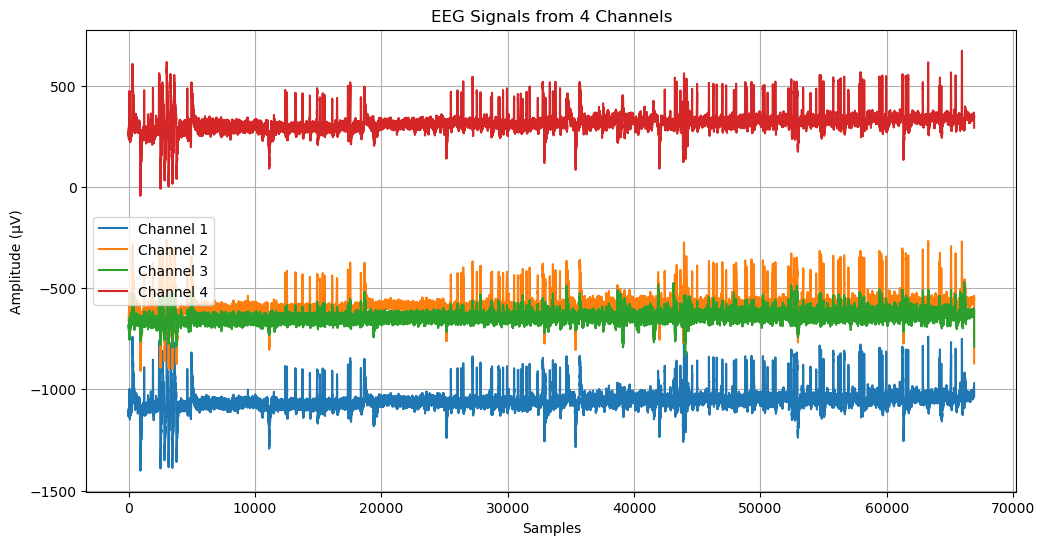

In [144]:
## Check Signals from 4 channels

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(raw[:, i] + i * 100, label=f"Channel {i+1}")
plt.title("EEG Signals from 4 Channels")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid()
plt.show()  

### Quality Check

In [145]:
def stats_per_channel(x_uv):
    cols = ["channel","mean_uv","median_uv","std_uv","abs_p95_uv","abs_p99_uv","min_uv","max_uv","rms_uv"]
    rows = []
    for i in range(x_uv.shape[1]):
        ch = x_uv[:, i]
        rows.append([
            CHANNEL_LABELS[i] if i < len(CHANNEL_LABELS) else f"ch{i+1}",
            float(np.mean(ch)),
            float(np.median(ch)),
            float(np.std(ch, ddof=1)),
            float(np.percentile(np.abs(ch), 95)),
            float(np.percentile(np.abs(ch), 99)),
            float(np.min(ch)),
            float(np.max(ch)),
            float(np.sqrt(np.mean(ch**2))),
        ])
    return pd.DataFrame(rows, columns=cols)

In [146]:
dur = raw.shape[0] / FS
display(Markdown(f"- Samples: **{raw.shape[0]:,}**  |  Duration: **{dur:.1f}s**  |  fs: **{FS} Hz**"))
display(Markdown("**Raw (before filter/re-ref) channel stats**"))
display(stats_per_channel(raw))

- Samples: **66,913**  |  Duration: **334.6s**  |  fs: **200 Hz**

**Raw (before filter/re-ref) channel stats**

,channel,mean_uv,median_uv,std_uv,abs_p95_uv,abs_p99_uv,min_uv,max_uv,rms_uv
0,Fp1,-1055.375689,-1059.951226,52.949165,1110.207253,1217.829307,-1402.189471,-719.915782,1056.703089
1,Fp2,-684.823833,-689.663731,52.638291,739.665072,844.158175,-1008.894112,-361.207018,686.843818
2,F7,-841.932257,-843.394189,28.798425,880.562811,920.292890,-1033.465254,-669.528110,842.424633
3,F8,17.023991,14.054544,50.235444,127.026824,216.272954,-343.414443,373.477629,53.041289


### Pass through Filter and rereference using CAR (common-average re-reference)

In [147]:
def apply_notch_and_bandpass(x, fs=FS, notch=NOTCH_HZ, band=BANDPASS):
    b_notch, a_notch = iirnotch(w0=notch/(fs/2), Q=30)
    x = filtfilt(b_notch, a_notch, x, axis=0)
    low, high = band
    b, a = butter(4, [low/(fs/2), high/(fs/2)], btype='band')
    x = filtfilt(b, a, x, axis=0)
    x = detrend(x, axis=0, type='constant')
    return x

def rereference(x, method="car"):
    if method == "car":
        return x - x.mean(axis=1, keepdims=True)
    return x

In [148]:
raw_f = apply_notch_and_bandpass(raw, fs=FS)
# raw_f = rereference(raw_f, REREF)

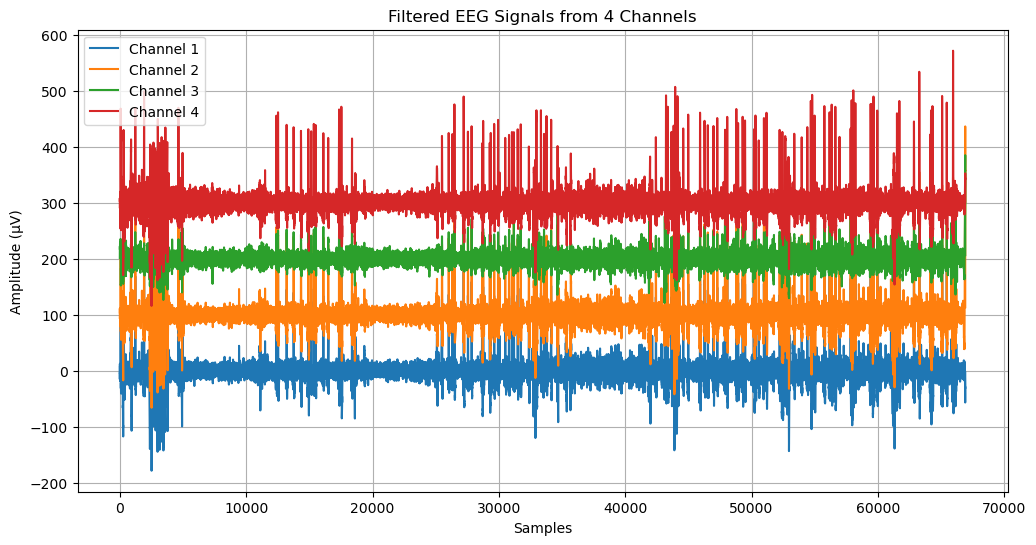

**Post-filter (+car) channel stats**

,channel,mean_uv,median_uv,std_uv,abs_p95_uv,abs_p99_uv,min_uv,max_uv,rms_uv
0,Fp1,-4.417464e-17,-1.270067,32.823101,70.337176,142.361806,-178.805265,249.766279,32.822856
1,Fp2,3.873776e-16,-1.336940,33.569305,72.319482,145.763485,-166.346203,336.245809,33.569054
2,F7,-1.359220e-16,-0.801351,14.793881,30.219043,52.837101,-79.115661,184.785338,14.793770
3,F8,-3.262127e-16,-1.255594,30.464122,64.500031,133.833636,-184.378898,271.452073,30.463894


In [149]:
## Vizualize

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(raw_f[:, i] + i * 100, label=f"Channel {i+1}")
plt.title("Filtered EEG Signals from 4 Channels")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid()
plt.show()

display(Markdown(f"**Post-filter (+{REREF}) channel stats**"))
display(stats_per_channel(raw_f))

### Combine the 4 channels using PCA

In [117]:
def combine_channels(x30, method="mean"):
    if method == "mean":
        return x30.mean(axis=1)
    if method == "rms":
        return np.sqrt((x30**2).mean(axis=1))
    if method == "pca1":
        return PCA(n_components=1).fit_transform(x30).ravel()
    if method in {"ch1","ch2","ch3","ch4"}:
        idx = {"ch1":0,"ch2":1,"ch3":2,"ch4":3}[method]
        return x30[:, idx]
    raise ValueError("Unknown COMBINE_METHOD")


In [118]:
X = np.asarray(raw)
combined = combine_channels(X, COMBINE_METHOD)
combined

array([137.77210935, 132.69208706, 128.87058118, ..., -66.77261826,
       -71.59526274, 162.35299268])

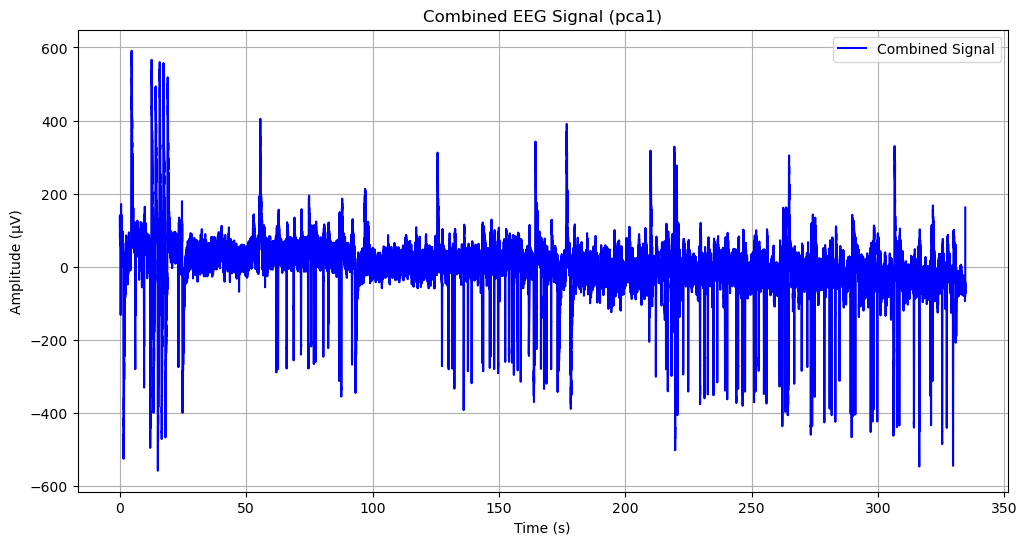

**Combined signal stats (pca1)**

,mean_uv,median_uv,std_uv,abs_p95_uv,abs_p99_uv,min_uv,max_uv,rms_uv
Combined,-9.525412e-14,7.745266,90.800368,218.232426,391.593411,-557.54674,591.05879,90.79969


In [119]:
X = np.asarray(raw)
combined = combine_channels(X, COMBINE_METHOD)
t = np.arange(combined.size) / FS

plt.figure(figsize=(12, 6))
plt.plot(t, combined, label="Combined Signal", color='blue')
plt.title(f"Combined EEG Signal ({COMBINE_METHOD})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid()
plt.show()

display(Markdown(f"**Combined signal stats ({COMBINE_METHOD})**"))
display(pd.DataFrame({
    "mean_uv": [np.mean(combined)],
    "median_uv": [np.median(combined)],
    "std_uv": [np.std(combined, ddof=1)],
    "abs_p95_uv": [np.percentile(np.abs(combined), 95)],
    "abs_p99_uv": [np.percentile(np.abs(combined), 99)],
    "min_uv": [np.min(combined)],
    "max_uv": [np.max(combined)],
    "rms_uv": [np.sqrt(np.mean(combined**2))],
}, index=["Combined"])) 

### Split Tasks

In [120]:
## Dynamically compute task windows based on total length
# It uses absolute task definitions if the total length is sufficient, otherwise falls back to sequential scheduling.
def compute_task_windows(total_len_sec):
    last_abs_end = max(s + d for _, s, d in ABS_TASKS)
    if SCHEDULE_MODE in ("absolute","auto") and total_len_sec >= last_abs_end:
        return [(name, start, dur) for (name, start, dur) in ABS_TASKS]
    if SCHEDULE_MODE == "absolute":
        wins = []
        for name, start, dur in ABS_TASKS:
            eff = max(0.0, min(dur, total_len_sec - start))
            wins.append((name, start, eff))
        return wins
    # sequential fallback
    wins, cur = [], SEQ_START_SEC
    for name in TASK_ORDER:
        dur = TASK_DUR_SEC.get(name, 30)
        eff = max(0.0, min(dur, total_len_sec - cur))
        wins.append((name, cur, eff))
        cur += dur
    return wins

def slice_task(x, start_s, dur_s, fs=FS):
    i0 = int(round(start_s * fs))
    i1 = min(i0 + int(round(dur_s * fs)), x.shape[0])
    return x[i0:i1]

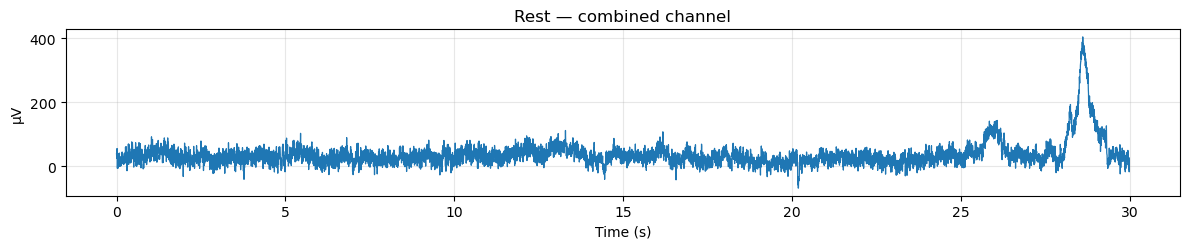

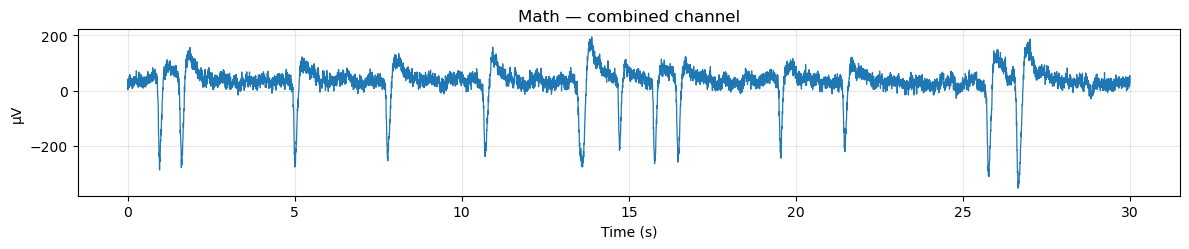

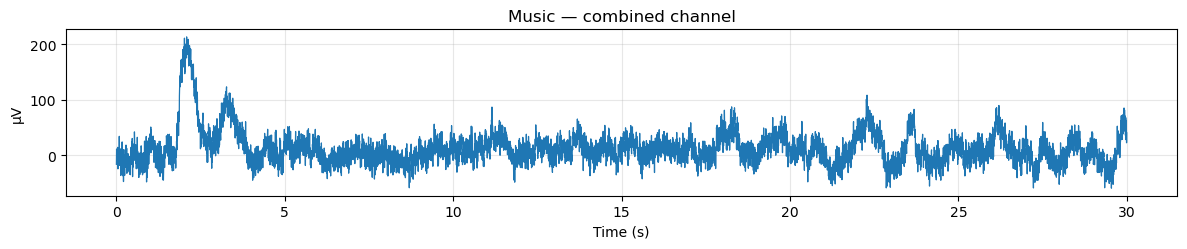

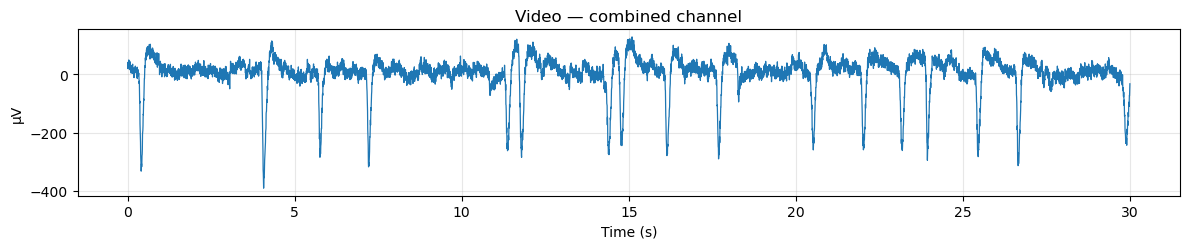

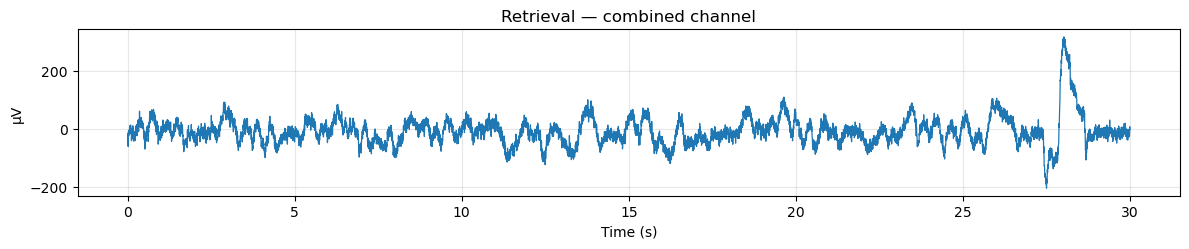

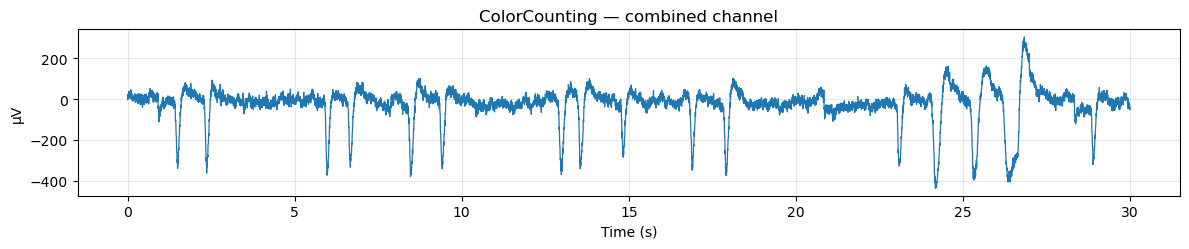

In [121]:
wins = compute_task_windows(total_len_sec)
for (task, t0, dur_eff) in wins:
    seg = slice_task(combined, t0, dur_eff)
    seg_len = seg.shape[0] / FS
    min_needed = CLEAN_EPOCH_SEC if ALLOW_SHORT_SEGMENTS else 30.0
    if seg_len < min_needed:
        print(f"  - {task}: segment too short ({seg_len:.1f}s), skipping")
        continue

    # store DataFrames (time + combined µV)
    if 'tasks_combined' not in locals():
        tasks_combined = {}
    tasks_combined[task] = pd.DataFrame({
        "t": np.arange(seg.size) / FS,
        "combined_uv": seg
    })

    # plot per task
    plt.figure(figsize=(12,2.6))
    plt.plot(tasks_combined[task]["t"], tasks_combined[task]["combined_uv"], lw=0.9)
    plt.title(f"{task} — combined channel"); plt.xlabel("Time (s)"); plt.ylabel("µV")
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

### Find Clean Epochs using Welch

In [122]:
def find_clean_epoch(x30, fs=FS, epoch_sec=CLEAN_EPOCH_SEC, thr=SPIKE_THRESHOLD_UV):
    n = x30.shape[0]
    w = int(epoch_sec * fs)
    if n < w: return None
    bad = (np.abs(x30) > thr).any(axis=1).astype(int)
    c = np.cumsum(np.concatenate([[0], bad]))
    best_i, best_v = 0, math.inf
    for i in range(0, n - w + 1):
        v = c[i+w] - c[i]
        if v < best_v:
            best_v, best_i = v, i
            if v == 0: break
    return x30[best_i:best_i+w, :]


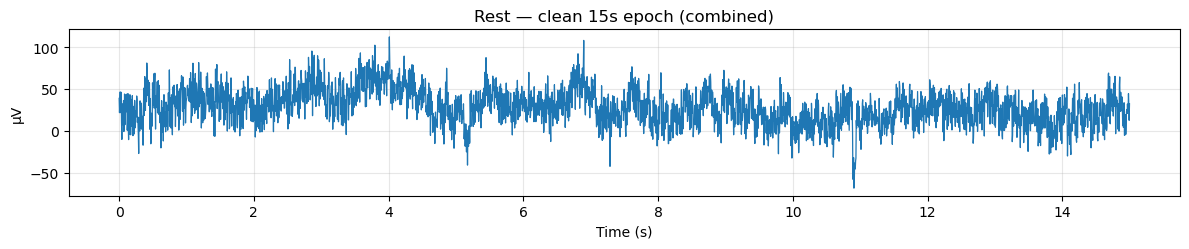

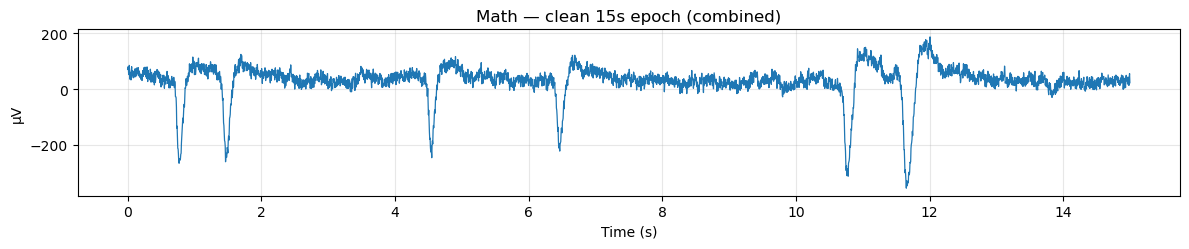

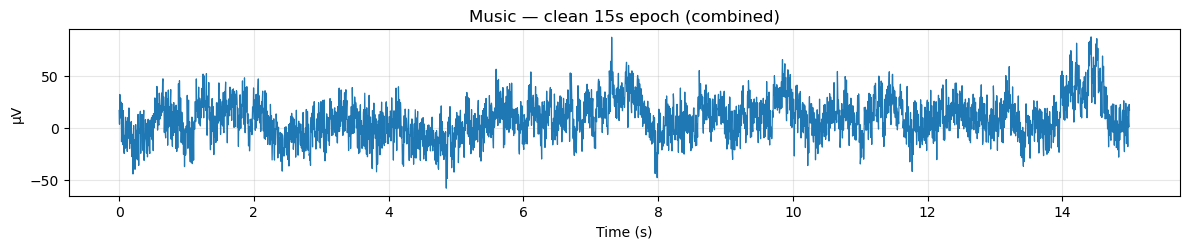

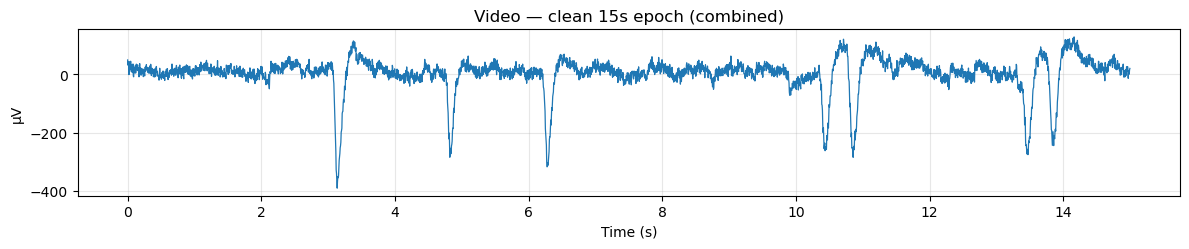

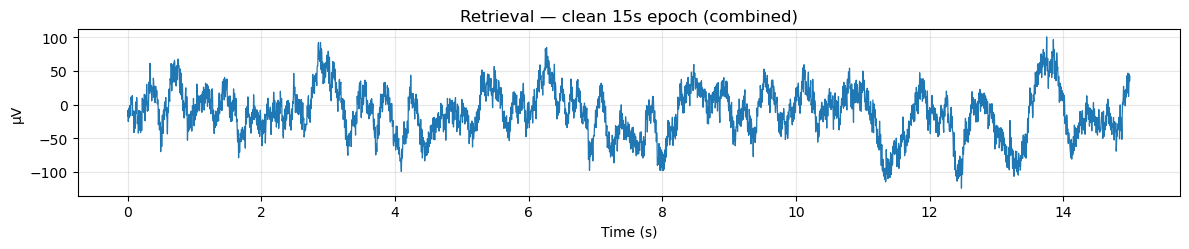

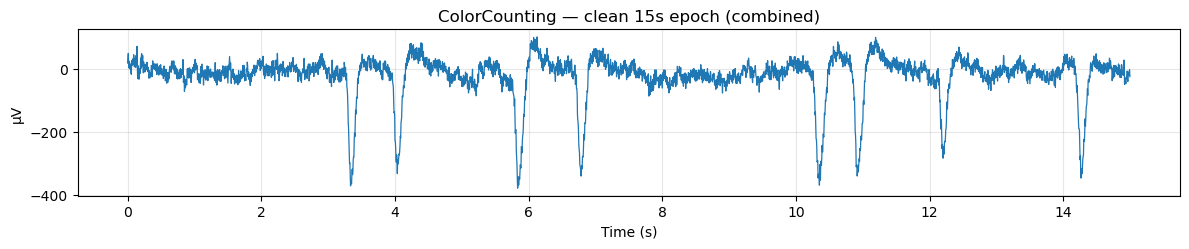

In [123]:
epochs_combined = {}
for task, df in tasks_combined.items():
    y = df["combined_uv"].to_numpy().reshape(-1, 1)
    epoch2d = find_clean_epoch(y)
    if epoch2d is None or epoch2d.shape[0] < int(CLEAN_EPOCH_SEC * FS):
        print(f" - {task}: no clean {CLEAN_EPOCH_SEC:.0f}s epoch found, skipping")
        continue

    epoch = epoch2d[:, 0]
    t = np.arange(epoch.size) / FS
    epochs_combined[task] = pd.DataFrame({"t": t, "combined_uv": epoch})

    plt.figure(figsize=(12, 2.6))
    plt.plot(t, epoch, lw=0.9)
    plt.title(f"{task} — clean {CLEAN_EPOCH_SEC:.0f}s epoch (combined)")
    plt.xlabel("Time (s)")
    plt.ylabel("µV")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### Find Band Powers

In [124]:
@dataclass
class Bands:
    delta: tuple = (0.5, 4.0)
    theta: tuple = (4.0, 8.0)
    alpha: tuple = (8.0, 12.0)
    beta:  tuple = (12.0, 30.0)
    lgam:  tuple = (30.0, 40.0)
BANDS = Bands()

def band_power(f, P, lo, hi):
    m = (f >= lo) & (f < hi)
    if not np.any(m): return np.nan
    df = np.mean(np.diff(f[m])) if np.sum(m) > 1 else (hi - lo)
    return np.sum(P[m]) * df

def band_metrics(f, P):
    d = {
        "delta": band_power(f,P,*BANDS.delta),
        "theta": band_power(f,P,*BANDS.theta),
        "alpha": band_power(f,P,*BANDS.alpha),
        "beta":  band_power(f,P,*BANDS.beta),
        "low_gamma": band_power(f,P,*BANDS.lgam),
    }
    d["tbr"] = d["theta"]/d["beta"] if (d["theta"]>0 and d["beta"]>0) else np.nan
    d["total_power_0p5_40"] = band_power(f,P,0.5,40.0)
    return d

In [125]:
def psd_median(x_epoch, fs=FS):
    psds = []
    for ch in range(x_epoch.shape[1]):
        f, Pxx = welch(x_epoch[:, ch], fs=fs, window='hann',
                       nperseg=N_PERSEG, noverlap=N_OVERLP, detrend=False,
                       average='median', scaling='density')
        psds.append(Pxx)
    psd_mean = np.mean(psds, axis=0)
    return f, psd_mean

def slice_0p5_to_40(f, P):
    m = (f >= 0.5) & (f <= 40.0)
    return f[m], P[m]

,delta,theta,alpha,beta,low_gamma,tbr,total_power_0p5_40,n_samples
task,,,,,,,,
Rest,408.387172,26.684442,23.670819,38.916807,12.852864,0.685679,510.512104,3000
Math,1754.373973,215.617160,24.156494,35.140849,9.257309,6.135798,2038.545785,3000
Music,119.663076,20.017994,21.264392,26.588314,6.550998,0.752887,194.084775,3000
Video,1858.759223,240.041268,29.943500,31.980153,7.589737,7.505945,2168.313881,3000
Retrieval,976.898937,40.574989,40.013577,26.563370,6.301121,1.527479,1090.351995,3000
ColorCounting,5897.208575,811.663333,75.786696,32.343615,10.888158,25.095009,6827.890378,3000


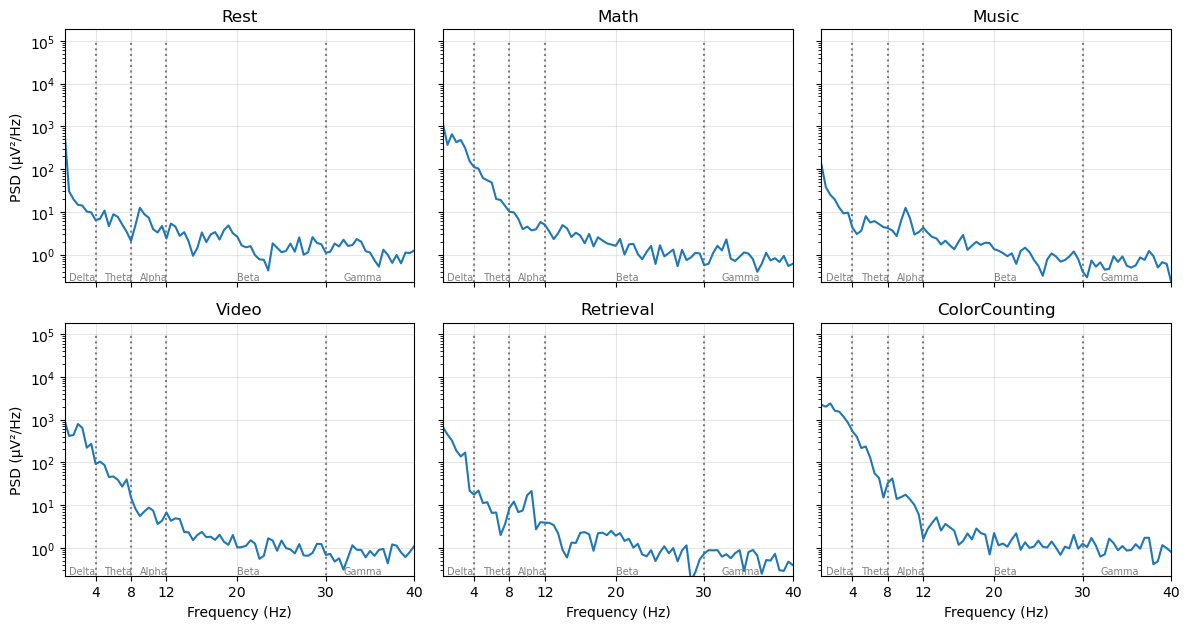

In [126]:
psd_curves = {}   # task -> (f2, P2)
rows = []         # band metrics
bands = [
    ("Delta", BANDS.delta),
    ("Theta", BANDS.theta),
    ("Alpha", BANDS.alpha),
    ("Beta",  BANDS.beta),
    ("Low-γ", BANDS.lgam),
    ]
xtickslist_f = [0,4,8,12,20,30,40]

for task, df in epochs_combined.items():
    # epochs_combined[task] has columns ["t", "combined_uv"]
    y = df["combined_uv"].to_numpy().reshape(-1, 1)  # shape (N,1) for psd_median
    f, P = psd_median(y, fs=FS)
    f2, P2 = slice_0p5_to_40(f, P)
    psd_curves[task] = (f2, P2)

    bm = band_metrics(f2, P2)
    bm.update(task=task, n_samples=int(y.shape[0]))
    rows.append(bm)

# ---- Show band metrics table
band_df = pd.DataFrame(rows).set_index("task")[["delta","theta","alpha","beta","low_gamma","tbr","total_power_0p5_40","n_samples"]]
display(band_df)

# ---- Plot PSDs per task
order = ["Rest","Math","Music","Video","Retrieval","ColorCounting"]
plot_order = [t for t in order if t in psd_curves] + [t for t in psd_curves if t not in order]
n = len(plot_order)
cols = 3
rows_n = int(np.ceil(n / cols)) if n else 1
fig, axes = plt.subplots(rows_n, cols, figsize=(12, 3.2*rows_n), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

for ax, task in zip(axes.ravel(), plot_order):
    f2, P2 = psd_curves[task]
    ax.semilogy(f2, P2)
    ax.set_title(task)
    ax.set_xticks(xtickslist_f)
    ax.set_xlim(0.5, 40.0)
    ax.vlines([4, 8, 12, 30], 0, 10e4, color='grey', linestyle='dotted')
    ax.text(1, 0.25, 'Delta', size=7, color='grey')
    ax.text(5, 0.25, 'Theta', size=7, color='grey')
    ax.text(9, 0.25, 'Alpha', size=7, color='grey')
    ax.text(20, 0.25, 'Beta', size=7, color='grey')
    ax.text(32, 0.25, 'Gamma', size=7, color='grey')
    ax.grid(True, alpha=0.3)

# tidy labels
for ax in axes[-1, :]:
    ax.set_xlabel("Frequency (Hz)")
for r in range(rows_n):
    axes[r, 0].set_ylabel("PSD (µV²/Hz)")

# hide unused subplots (if any)
for ax in axes.ravel()[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### ISSUES to be addressed:

1) The combined series shows std ≈ 90 µV and outliers up to ±600 µV which could happen due to synchronous artifacts (blinks & eye movements, jaw clenching). Fp1/Fp2 are right over the eyes; so they are adding issues. 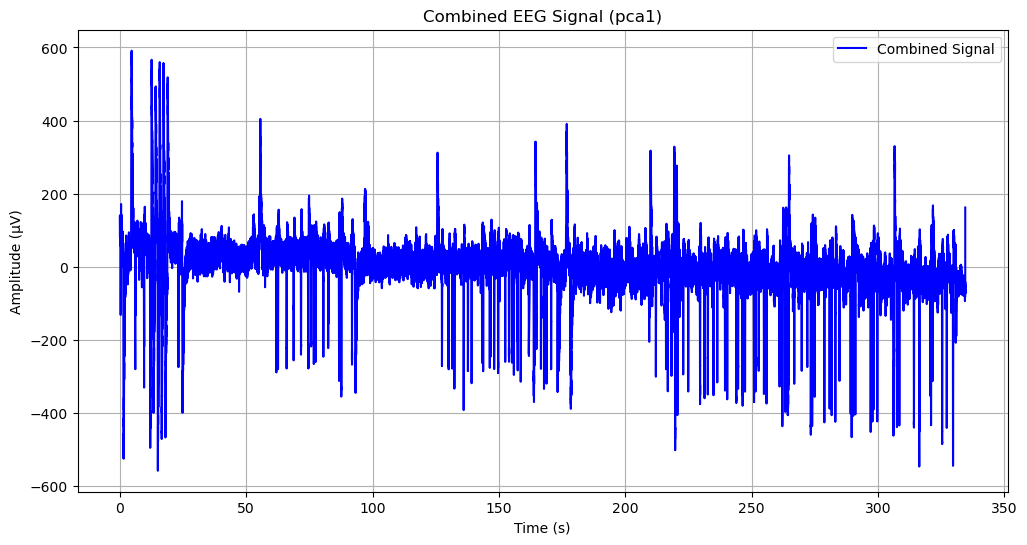 <br>
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_uv</th>
      <th>median_uv</th>
      <th>std_uv</th>
      <th>abs_p95_uv</th>
      <th>abs_p99_uv</th>
      <th>min_uv</th>
      <th>max_uv</th>
      <th>rms_uv</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Combined</th>
      <td>-9.460169e-14</td>
      <td>7.745266</td>
      <td>90.800368</td>
      <td>218.232426</td>
      <td>391.593411</td>
      <td>-557.54674</td>
      <td>591.05879</td>
      <td>90.79969</td>
    </tr>
  </tbody>
</table>
</div>
<br>
    Solution- Use only F7 andb F8 channels for PSD and use something like ICA(Indepenedent component Analysis) for filtering out the artifacts.
<br> <br>

2) Very High Theta and Delta values- This could happen because I chose high-pass of 0.5Hz, and any slow drift that squeaks through still inflates the very-low-frequency bins. Many cognitive EEG pipelines use 1–2 Hz high-pass for spectral work to suppress residual drift and EOG. 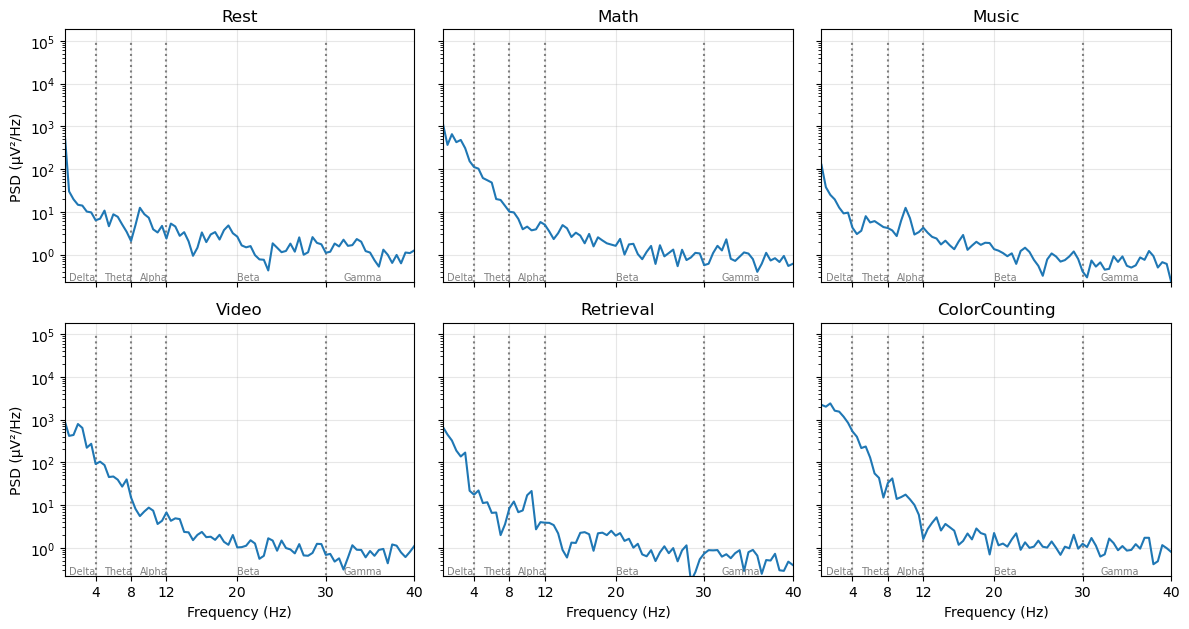 <br>
Solution- Raise the high-pass to 1 Hz (or 2 Hz) for PSD plots.

## Implement ICA and use only F7/F8 channels for PSD analysis

In [ ]:
# ---- Fit ICA ----

# 1) Fit ICA
raw_f = apply_notch_and_bandpass(raw, fs=FS)
X  = np.asarray(raw_f)
Xz = (X - X.mean(axis=0, keepdims=True)) / (X.std(axis=0, keepdims=True) + 1e-9) # Standardize channels (ICA assumption)
ica = FastICA(n_components=4, algorithm="parallel",
              whiten="unit-variance", fun="logcosh",
              max_iter=5000, tol=1e-5, random_state=42)
S = ica.fit_transform(Xz)           # (N,4) sources
A = ica.mixing_                     # (4,4) mixing/topography

# 2) EOG proxy and helper scores
eog_proxy = (Xz[:,0] + Xz[:,1]) / 2.0
eog_proxy = (eog_proxy - eog_proxy.mean()) / (eog_proxy.std()+1e-9)

def lf_ratio(sig, fs=FS, split=3.0):
    f, P = welch(sig, fs=fs, window="hann",
                 nperseg=int(2*fs), noverlap=int(fs),
                 average="median", detrend=False, scaling="density")
    m1 = (f>=0.5) & (f<split); m2 = (f>=split) & (f<=40.0)
    return (np.trapz(P[m1], f[m1])+1e-12) / (np.trapz(P[m2], f[m2])+1e-12)

rows = []
for i in range(S.shape[1]):
    si   = (S[:,i] - S[:,i].mean()) / (S[:,i].std()+1e-9)
    corr = np.corrcoef(si, eog_proxy)[0,1]
    lfr  = lf_ratio(si, FS, split=3.0)
    kurt = kurtosis(si, fisher=True, bias=False)

    # frontal loading (Fp vs F7/F8) from mixing matrix column i
    fp_load = np.sum(np.abs(A[[0,1], i]))  # Fp1,Fp2
    lf_load = np.sum(np.abs(A[[2,3], i]))  # F7,F8
    fp_ratio = fp_load / (lf_load + 1e-9)
    rows.append([i, corr, lfr, kurt, fp_ratio])

scores = pd.DataFrame(rows, columns=["comp","corr_eog","lf_ratio<3Hz","kurtosis","fp_ratio(Fp/F7-8)"])
display(scores.style.format({"corr_eog":"{:.2f}","lf_ratio<3Hz":"{:.2f}","kurtosis":"{:.1f}","fp_ratio(Fp/F7-8)":"{:.2f}"}))

# 3) Selection rule (STRONGER): require frontal topography + one other criterion
blink_like = []
for comp, corr, lfr, kurt, fp_ratio in rows:
    is_frontal = fp_ratio >= 1.3            # heavier on Fp than F7/F8
    blinky     = (abs(corr) >= 0.50 and lfr >= 1.8)
    spiky      = (kurt >= 20)               # rare huge transients
    if is_frontal and (blinky or spiky):
        blink_like.append(comp)

# Drop at most 2 components
blink_like = blink_like[:2]
print("Components to remove (conservative):", blink_like)

# 4) Reconstruct or FALL BACK to regression
if len(blink_like) == 0 or len(blink_like) >= S.shape[1]:
    # Fallback: regress out Fp mean from F7/F8 (robust with 4ch)
    Fp = ((X[:,0] + X[:,1]) / 2.0)[:, None]
    Y  = X[:, 2:4]                               # F7,F8
    beta = np.linalg.lstsq(Fp, Y, rcond=None)[0]
    Yc = Y - Fp @ beta
    X_clean = X.copy()
    X_clean[:, 2:4] = Yc
    note = "Fallback regression (Fp→F7/F8)"
else:
    S_clean = S.copy()
    S_clean[:, blink_like] = 0
    # Undo z-scoring
    X_clean = (S_clean @ A.T) * (X.std(axis=0, keepdims=True)+1e-9) + X.mean(axis=0, keepdims=True)
    note = f"ICA removed comps {blink_like}"

print("Cleanup method:", note)


,comp,corr_eog,lf_ratio<3Hz,kurtosis,fp_ratio(Fp/F7-8)
0,0,0.06,0.15,1446.8,0.84
1,1,-0.05,0.39,3.0,0.27
2,2,0.99,1.82,11.1,1.17
3,3,-0.15,1.06,6.5,0.41


Components to remove (conservative): []
Cleanup method: Fallback regression (Fp→F7/F8)


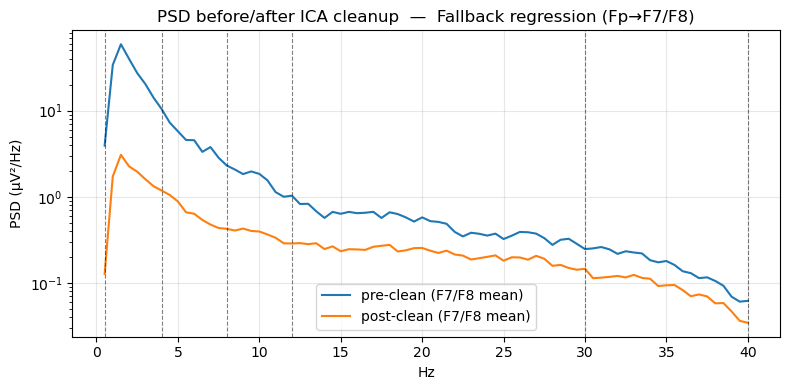

95th |amp| pre/post (µV): 44.3 → 9.3


In [150]:
# Quick QA on lateral-frontal combine
raw_f = apply_notch_and_bandpass(raw, fs=FS)
X  = np.asarray(raw_f)
def psd(sig, fs=FS):
    f, P = welch(sig, fs=fs, window="hann",
                 nperseg=int(2*fs), noverlap=int(fs),
                 average="median", detrend=False, scaling="density")
    m = (f>=0.5) & (f<=40.0)
    return f[m], P[m]

comb_pre  = X[:, 2:4].mean(axis=1)
comb_post = X_clean[:, 2:4].mean(axis=1)
f0, P0 = psd(comb_pre); f1, P1 = psd(comb_post)

plt.figure(figsize=(8,4))
plt.semilogy(f0, P0, label="pre-clean (F7/F8 mean)")
plt.semilogy(f1, P1, label="post-clean (F7/F8 mean)")
for edge in [0.5,4,8,12,30,40]:
    plt.axvline(edge, ls="--", lw=0.8, alpha=0.5, color="k")
plt.legend(); plt.xlabel("Hz"); plt.ylabel("PSD (µV²/Hz)")
plt.title(f"PSD before/after ICA cleanup  —  {note}")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("95th |amp| pre/post (µV):",
      np.percentile(np.abs(comb_pre), 95).round(1), "→",
      np.percentile(np.abs(comb_post), 95).round(1))


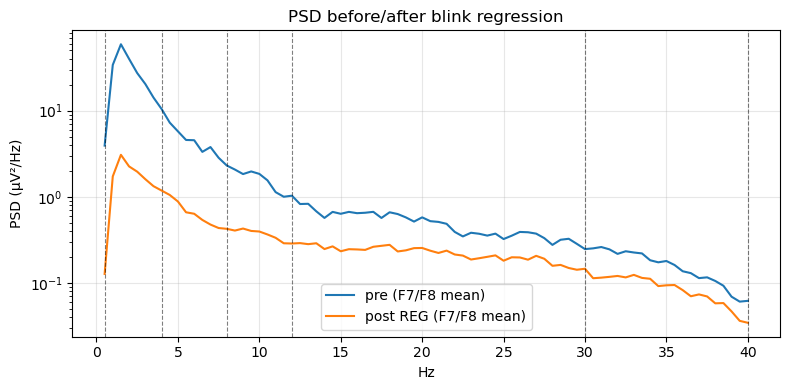

95th |amp| (µV): 44.3 → 9.3


In [143]:
# Regress Fp (blink proxy) out of F7/F8
raw_f = apply_notch_and_bandpass(raw, fs=FS)
X  = np.asarray(raw_f)
Fp = ((X[:,0] + X[:,1]) / 2.0)[:, None]   # N×1
Y  = X[:, 2:4]                             # F7,F8  (N×2)

beta = np.linalg.lstsq(Fp, Y, rcond=None)[0]   # (1×2)
Y_clean = Y - Fp @ beta                        # N×2

# Compare PSDs of F7/F8 mean pre vs post-regression
def psd(sig, fs=FS):
    f, P = welch(sig, fs=fs, window="hann",
                 nperseg=int(2*fs), noverlap=int(fs),
                 average="median", detrend=False, scaling="density")
    m = (f>=0.5) & (f<=40.0); return f[m], P[m]

comb_pre  = Y.mean(axis=1)
comb_post = Y_clean.mean(axis=1)

f0,P0 = psd(comb_pre); f1,P1 = psd(comb_post)
plt.figure(figsize=(8,4))
plt.semilogy(f0,P0,label="pre (F7/F8 mean)")
plt.semilogy(f1,P1,label="post REG (F7/F8 mean)")
for x in [0.5,4,8,12,30,40]: plt.axvline(x, ls="--", lw=0.8, alpha=0.5, color="k")
plt.legend(); plt.xlabel("Hz"); plt.ylabel("PSD (µV²/Hz)")
plt.title("PSD before/after blink regression"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

p95_pre  = np.percentile(np.abs(comb_pre), 95)
p95_post = np.percentile(np.abs(comb_post), 95)
print(f"95th |amp| (µV): {p95_pre:.1f} → {p95_post:.1f}")

### Final Pipeline

        1) Notch + band-pass (e.g., 1–40 Hz)

        2) Blink cleanup (pre-CAR regression or ICA)

        3) CAR (robust)

        4) Combine channels (e.g., F7/F8 mean)

        5) Split Tasks

        6) Find clean 15s epoch

        7) PSD

# Analysis

### Rest PSDs per condition

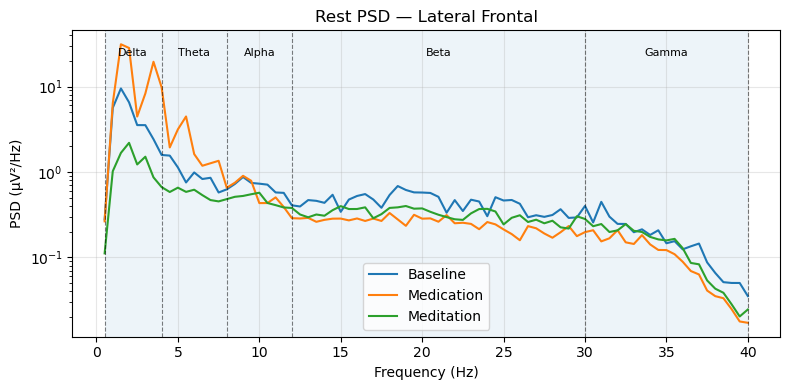

In [157]:
conds = ["baseline","medication","meditation"]
paths = {c: f"./output/psd80/{c}_Rest__lateral_frontal.csv" for c in conds}

plt.figure(figsize=(8,4))
for c in conds:
    df = pd.read_csv(paths[c])
    freqs = np.array([float(col.replace("Hz","")) for col in df.columns])
    psd = df.values.mean(axis=0)               # mean across days 1–7
    plt.semilogy(freqs, psd, label=c.capitalize())

# band markers
for x in [0.5,4,8,12,30,40]:
    plt.axvline(x, ls="--", lw=0.8, alpha=0.5, color="k")
for name,(lo,hi) in [("Delta",(0.5,4)),("Theta",(4,8)),("Alpha",(8,12)),("Beta",(12,30)),("Gamma",(30,40))]:
    plt.axvspan(lo,hi,alpha=0.08); plt.text((lo+hi)/2, plt.ylim()[1]/1.6, name, ha="center", va="top", fontsize=8)

plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (µV²/Hz)")
plt.title("Rest PSD — Lateral Frontal")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [158]:
PSD_DIR = "output/psd80"
OUT_LONG = "output/psd80/_ALL_psd80_long.csv" 
OUT_WIDE = "output/psd80/_ALL_psd80_wide.csv" 

TASKS = ["Rest","Math","Music","Video","Retrieval","ColorCounting"]
CONDS = ["baseline","medication","meditation"]

def _parse_filename(fn):
    m = re.match(r"^(baseline|medication|meditation)_(Rest|Math|Music|Video|Retrieval|ColorCounting)(?:__([A-Za-z0-9_]+))?\.csv$", fn)
    if not m: return None
    cond, task, group = m.group(1), m.group(2), (m.group(3) or "ungrouped")
    return cond, task, group

def _parse_freq_cols(df):
    freqs, cols = [], []
    for c in df.columns:
        s = str(c).replace("Hz","").replace("f","").replace("F","").replace("p",".")
        m = re.findall(r"[-+]?\d*\.?\d+", s)
        if not m: 
            continue
        try:
            freqs.append(float(m[0])); cols.append(c)
        except ValueError:
            pass
    return np.array(freqs, float), cols

def merge_psd_to_single_csv(psd_dir=PSD_DIR, out_long=OUT_LONG, out_wide=OUT_WIDE, include_groups=None):
    rows_long = []
    meta_seen = set()
    for fn in sorted(os.listdir(psd_dir)):
        if not fn.endswith(".csv"):
            continue
        parsed = _parse_filename(fn)
        if not parsed:
            continue
        cond, task, group = parsed
        if cond not in CONDS or task not in TASKS:
            continue
        if include_groups and group not in include_groups:
            continue

        path = os.path.join(psd_dir, fn)
        df = pd.read_csv(path)
        freqs, cols = _parse_freq_cols(df)
        if freqs.size == 0:
            print(f"[skip] no numeric freq columns in {path}")
            continue
        P = df[cols].values.astype(float)  # rows=days, cols=freqs

        for day_idx in range(P.shape[0]):
            rows_long.append(pd.DataFrame({
                "condition": cond,
                "task": task,
                "day": day_idx+1,
                "group": group,
                "freq_hz": freqs,
                "power_uV2_per_Hz": P[day_idx, :]
            }))
        meta_seen.add((cond, task, group, P.shape[0], freqs.size))

    if not rows_long:
        raise RuntimeError(f"No PSD rows found in {psd_dir}.")

    # ---- LONG tidy table
    all_long = pd.concat(rows_long, ignore_index=True)
    # Ensure numeric types (prevents mixed-dtype surprises)
    all_long["freq_hz"] = pd.to_numeric(all_long["freq_hz"], errors="coerce")
    all_long["power_uV2_per_Hz"] = pd.to_numeric(all_long["power_uV2_per_Hz"], errors="coerce")
    all_long.dropna(subset=["freq_hz","power_uV2_per_Hz"], inplace=True)

    os.makedirs(os.path.dirname(out_long), exist_ok=True)
    all_long.to_csv(out_long, index=False)
    print(f"Saved LONG table -> {out_long}  ({len(all_long):,} rows)")

    # ---- WIDE table (no sort_index on mixed types)
    wide = (all_long
            .pivot_table(index=["condition","task","day","group"],
                         columns="freq_hz",
                         values="power_uV2_per_Hz",
                         aggfunc="mean")
            .reset_index())

    # rename numeric freq columns to strings and order them numerically
    meta_cols = ["condition","task","day","group"]
    freq_cols_num = [c for c in wide.columns if c not in meta_cols]  # these are numeric
    # map to "0.5Hz" strings
    rename_map = {c: f"{float(c):.3g}Hz" for c in freq_cols_num}
    wide = wide.rename(columns=rename_map)
    freq_cols_str = sorted(rename_map.values(), key=lambda s: float(s.replace("Hz","")))

    wide = wide[meta_cols + freq_cols_str]
    wide.to_csv(out_wide, index=False)
    print(f"Saved WIDE table -> {out_wide}  ({len(wide):,} rows × {wide.shape[1]} cols)")

    print("\nSummary (found files):")
    for item in sorted(meta_seen):
        cond, task, group, ndays, nfreq = item
        print(f" - {cond}/{task}/{group}: days={ndays}, freqs={nfreq}")

    return all_long, wide

# ---- run it (lateral_frontal only) ----
_ = merge_psd_to_single_csv(include_groups=["all", "lateral_frontal","frontopolar"])


Saved LONG table -> output/psd80/_ALL_psd80_long.csv  (30,240 rows)
Saved WIDE table -> output/psd80/_ALL_psd80_wide.csv  (378 rows × 84 cols)

Summary (found files):
 - baseline/ColorCounting/all: days=7, freqs=80
 - baseline/ColorCounting/frontopolar: days=7, freqs=80
 - baseline/ColorCounting/lateral_frontal: days=7, freqs=80
 - baseline/Math/all: days=7, freqs=80
 - baseline/Math/frontopolar: days=7, freqs=80
 - baseline/Math/lateral_frontal: days=7, freqs=80
 - baseline/Music/all: days=7, freqs=80
 - baseline/Music/frontopolar: days=7, freqs=80
 - baseline/Music/lateral_frontal: days=7, freqs=80
 - baseline/Rest/all: days=7, freqs=80
 - baseline/Rest/frontopolar: days=7, freqs=80
 - baseline/Rest/lateral_frontal: days=7, freqs=80
 - baseline/Retrieval/all: days=7, freqs=80
 - baseline/Retrieval/frontopolar: days=7, freqs=80
 - baseline/Retrieval/lateral_frontal: days=7, freqs=80
 - baseline/Video/all: days=7, freqs=80
 - baseline/Video/frontopolar: days=7, freqs=80
 - baseline/Vid